In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import pandana as pdna
import geopandas as gpd
import pandas as pd
import math
import networkx as nx
import sys
# adding functions 
sys.path.insert(0, 'C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Other Cities\\Open-Walk-Index')
from walkability_functions import *

Choose a projected CRS to be used for all distance calculations.

In [4]:
proj_crs = "EPSG:7856"

## Import Data

Data sources:
1. Shape of Greater Sydney - used to clip points
2. Points of interest from OSM - using Geofabriks shapefiles as the source
3. Transport for NSW public transport stops
4. Spatial Services NSW for additional POIs
5. Employment data - processed from ABS originally

In [189]:
folder = "C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\"
Sutherland = gpd.read_file((folder + 
    "Walkability\\Other Cities\\Colouring data & results\\Sydney Data\\Data\\Sutherland LGA.gpkg")
    ).to_crs(proj_crs)

In [92]:
osm_poi_points = gpd.read_file(''.join((folder, 
    "Walkability\\Mavoa\\Pandana inputs\\Greater_Sydney_OSM_POIs_sp.shp")))
osm_poi_areas = gpd.read_file(folder + 
    "Walkability\\Mavoa\\Pandana inputs\\Greater_Sydney_OSM_POIs_a_sp.gpkg")
osm_transport_points = gpd.read_file(folder +
    "Walkability\\Mavoa\\Pandana inputs\\Greater_Sydney_OSM_transport_sp.shp")
osm_transport_areas =  gpd.read_file(folder +
    "Data\\OSM-australia-latest-free\\gis_osm_transport_a_free_1.shp")
osm_pow_points = gpd.read_file(folder + 
    "Data\\OSM-australia-latest-free\\gis_osm_pofw_free_1.shp")
osm_pow_areas = gpd.read_file(folder + 
    "Data\\OSM-australia-latest-free\\gis_osm_pofw_a_free_1.shp")
osm_natural = gpd.read_file(folder + 
    "Data\\OSM-australia-latest-free\\gis_osm_natural_a_free_1.shp")
osm_govt_points = gpd.read_file(folder + 
    "Walkability\\Other Cities\\Colouring data & results\\Shared Aus Data\\OSM government offices.gpkg",
                             layer = "OSM government offices points").to_crs(osm_natural.crs)
osm_govt_points['fclass'] = 'government'
osm_govt_areas = gpd.read_file(folder + 
    "Walkability\\Other Cities\\Colouring data & results\\Shared Aus Data\\OSM government offices.gpkg",
                             layer = "OSM government offices areas").to_crs(osm_natural.crs)
osm_govt_areas['fclass'] = 'government'

# the OSM POIs includes domestic swimming pools in some suburbs. This line removes swimming pools less than 100m2.
# Same for domestic tennis courts appearing as 'pitches'. Removed pitches below 450m2.
osm_poi_areas = osm_poi_areas[~((osm_poi_areas['fclass']=='swimming_pool') & (osm_poi_areas.to_crs(proj_crs).area < 100))]
osm_poi_areas = osm_poi_areas[~((osm_poi_areas['fclass']=='pitch') & (osm_poi_areas.to_crs(proj_crs).area < 450))]

In [7]:
# import SS NSW data
SS_NSW = gpd.read_file((folder + 
                        "Data\\NSW Spatial Services\\NSW_Features_of_Interest_Category.gdb"),layer='BuildingComplexPoint')
SS_NSW.to_crs(Sutherland.crs, inplace = True)
SS_NSW['fclass'] = (SS_NSW['classsubtype'].astype(str) + "-" 
                    + SS_NSW['buildingcomplextype'].astype(str))

# add general cultural points
SS_NSW_gc = gpd.read_file((folder + 
                           "Data\\NSW Spatial Services\\NSW_Features_of_Interest_Category.gdb"),layer='GeneralCulturalPoint')
SS_NSW_gc.to_crs(Sutherland.crs, inplace = True)
SS_NSW_gc['fclass'] = (SS_NSW_gc['classsubtype'].astype(str) + "-" 
                       + SS_NSW_gc['generalculturaltype'].astype(str) + "-gc")

SS_NSW = pd.concat([SS_NSW, SS_NSW_gc]).to_crs(proj_crs)

In [8]:
SS_names = {'4-10': 'shopping centre', '2-18': 'post office', '2-16': 'place of worship',
 '3-3': 'health centre', '3-5': 'health centre', '3-6': 'health centre',
 '1-1': 'school', '1-2': 'school', '1-3': 'school', '1-5': 'school', '1-6': 'school',
 '1-8': 'school', '1-4': 'university', '1-7': 'childcare',
 '2-2': 'art gallery', '2-11': 'library', '2-14': 'museum',
 '6-12': 'sports centre', '6-18': 'zoo', '1-6-gc': 'outdoor theater',
 '6-15': 'swimming pool', '9-2-gc': 'swimming pool',
 '6-17': 'tourist attraction', '1-2-gc': 'golf course', '1-5-gc': 'lookout',
 '1-7-gc': 'park', '1-8-gc': 'picnic area', '1-12-gc': 'sports field', '1-13-gc': 'sports field'}

SS_NSW.replace({'fclass': SS_names},inplace=True)

In [136]:
employment_centrs = gpd.read_file((folder + 
                        "Walkability\\Other Cities\\Colouring data & results\\Sydney Data\\Data\\NSW_Employment_meshblocks.gpkg"),
                                  layer='centroids').to_crs(proj_crs)
    #"Data\\Colouring\\Centroids employment MBs.gpkg")

Convert polygonal datasets to points and any multipart datasets to single part.

In [120]:
osm_pois_2 = single_points(osm_poi_areas)
osm_transport_2 = single_points(osm_transport_areas)
osm_pow_2 = single_points(osm_pow_areas)
osm_natural_2 = single_points(osm_natural)
osm_govt_2 = single_points(osm_govt_areas)

osm_df = pd.concat([osm_poi_points, osm_pois_2, osm_transport_points, osm_govt_points,
                    osm_transport_2, osm_pow_points, osm_pow_2, osm_natural_2, osm_govt_2]).to_crs(proj_crs)

osm_df = gpd.clip(osm_df, Sutherland).iloc[:,0:5]

### Residential population

In [11]:
meshblocks = pd.read_csv(''.join(folder + "Data\\ABS Data\\2016 census mesh block counts.csv"))
mb_shapes = gpd.read_file(''.join(folder + "Data\\ABS Data\\2016_NSW_MBs\\MB_2016_NSW.shp"))

In [12]:
mb_shapes['MB_CODE16'] = mb_shapes['MB_CODE16'].astype('int64')

pop_mbs = mb_shapes.join(meshblocks.set_index('MB_CODE_2016'), on='MB_CODE16', how='inner', rsuffix='_2')
pop_mbs['geometry'] = pop_mbs['geometry'].to_crs(proj_crs).centroid

pop_pois = pop_mbs[(pop_mbs['Person'] > 0) & ~(pop_mbs['geometry'].isnull())][
    ['MB_CODE16', 'MB_CATEGORY_NAME_2016', 'AREA_ALBERS_SQKM', 'Person','geometry']]
pop_pois['fclass'] = 'residential'

 10,000 for population? Micropolitan size?
 For jobs: Colin Clark reports that cities need 100,000-200,000 in order to provide an adequate range of commercial services. 200-500k to support broadly based manufacturing activity.

### Categorise and weight POIs

Choose walk index weightings, and output the sums of each category and the total to check. The walk index will be out of 100 regardless of this sum, but it is important to note that eg. shopping is only '10% of the walk index' if shopping is 10 out of 100.

In [13]:
poi_weights = {
    "employment": 29,
    "education": 13,
    "daily needs": 13.8,
    "other goods": 5.8,
    "services": 1.5,
    "medical": 3.6,
    "errands": 1.5,
    "visiting": 9.4,
    "cultural": 1.5,
    "events": 1.5,
    "sports": 4.4,
    "restaurants": 3.6,
    "day trip": 0.7,
    "walk/jog/ride": 5.1,
    "walk dog": 2.9,
    "religious": 1.5,
    "accompany children": 1.5,
}

poi_numbers = {
    "employment": 100,
    "education": 5,
    "daily needs": 5,
    "other goods": 5,
    "services": 5,
    "medical": 5,
    "errands": 5,
    "visiting": 5,
    "cultural": 5,
    "events": 5,
    "sports": 5,
    "restaurants": 5,
    "day trip": 5,
    "walk/jog/ride": 5,
    "walk dog": 5,
    "religious": 5,
    "accompany children": 5,
}


In [ ]:
poi_numbers = {
    "employment": 100,
    "education": 5,
    "daily needs": 5,
    "other goods": 5,
    "services": 5,
    "medical": 5,
    "errands": 5,
    "visiting": 5,
    "cultural": 5,
    "events": 5,
    "sports": 5,
    "restaurants": 5,
    "day trip": 5,
    "walk/jog/ride": 5,
    "walk dog": 5,
    "religious": 5,
    "accompany children": 5,
}


In [14]:
#category_sums = {k: sum(v) for k, v in poi_weights.items()}
#print(category_sums)
total = sum(poi_weights.values())
print("total: ", total)

total:  100.3


The purpose of this section now is just to align the different sources of information so that their tags are in the same column, eg 'category'. 

Categorise POI data - change classes depending on your analysis and your data sources.

In [121]:
poi_categories = {'employment':[],
                  'daily needs' : ['supermarket', 'greengrocer','butcher','convenience',
                                   'kiosk', 'beverages', 'alcohol', 'bakery', ],
                  'other goods' : ["shopping centre", 'mall', 'bicycle_shop', 'clothes', 'department_store', 
                                   'doityourself', 'beauty_shop', 'outdoor_shop', 
                                   'stationery', 'bookshop', 'gift_shop', 'newsagent', 
                                   'car_dealership', 'furniture_shop', 'sports_shop',
                                   'garden_centre', 'computer_shop', 'shoe_shop', 'florist', 
                                   'video_shop', 'toy_shop', 'mobile_phone_shop', 'jeweller'],
                  'services': ['hairdresser', 'optician', 'travel_agent','laundry', 'veterinary', ],                 
                  'medical': ["health centre",'chemist', 'pharmacy','doctors', 'dentist','hospital',],                  
                  'errands' : ["post office",'post_box', 'post_office', 'bank', 'atm',
                               'courthouse', 'government' ], 
                  'education' : ["childcare", 'college', 'school', 'kindergarten', 'university'],
                  'visiting' : ['residential'],
                  'cultural' : ["art gallery", "outdoor theater", 'arts_centre', 'theatre', 'artwork',
                                'library','archaeological', 'cinema', 'museum', 'ruins',],
                  'events' : ['stadium', 'marketplace', 'community_centre', 'library',],
                  'sports' : ["sports centre", "sports field", "swimming pool", "golf course", 
                              'ice_rink','pitch', 'swimming_pool', 'sports_centre', 
                              'golf_course', 'track',],
                  'further education' : ['community_centre', 'library','college'],
                  'restaurants' : ['restaurant', 'pub', 'cafe', 'fast_food', 'bar',  
                                   'food_court', 'nightclub', 'biergarten',],
                  'day trip' : ["tourist attraction", "lookout", 'attraction', 'zoo', 'castle', 
                                'theme_park',],
                  'walk/jog/ride' : ['park', 'viewpoint', 'beach'],
                  'walk dog' : ['dog_park', 'park',],
                  'religious' : ["place of worship", 'graveyard', 'christian_anglican', 'muslim',
                                'christian', 'christian_catholic', 'christian_protestant',
                                'christian_lutheran', 'hindu', 'christian_evangelical',
                                'christian_methodist', 'buddhist', 'sikh', 'christian_orthodox', 'jewish',
                                'muslim_sunni', 'taoist', 'muslim_shia'],
                  'hobby' : [],
                  'accompany children' : ['playground', 'library',],
                    }

osm_categorised = categorise_pois(osm_df, poi_categories, 
                                  old_column='fclass')
SS_categorised = categorise_pois(SS_NSW, poi_categories, 
                                 old_column='fclass')
pop_categorised = categorise_pois(pop_pois, poi_categories, 
                                 old_column='fclass')

Tags present in the dataset but not categorised:
['bench' 'toilet' 'memorial' 'tourist_info' 'caravan_site' 'fire_station'
 'railway_station' 'drinking_water' 'motel' 'waste_basket' 'camp_site'
 'picnic_site' 'telephone' 'comms_tower' 'tower' 'water_works' 'bus_stop'
 'nursing_home' 'public_building' 'police' 'shelter' 'tram_stop'
 'fountain' 'guesthouse' 'car_wash' 'recycling' 'observation_tower'
 'vending_machine' 'bus_station' 'taxi' 'water_tower' 'monument'
 'camera_surveillance' 'hostel' 'recycling_clothes' 'vending_any'
 'car_rental' 'recycling_glass' 'wastewater_plant' 'lighthouse']
Tags present in the dataset but not categorised:
['4-6' '2-24' '5-9' '2-0' '5-10' '2-8' '2-12' '3-0' '2-4' '6-3' '2-17'
 '2-21' '2-20' '2-9' '5-8' '4-7' '4-4' '4-8' '2-23' '1-0' '3-1' '2-19'
 '2-5' '4-0' '2-6' '2-7' '2-1' '5-1' '4-1' '2-10' '2-15' '5-5' '5-11'
 '5-2' '4-2' '4-3' '5-3' '4-9' '5-6' '3-4' '5-7' '6-0' '5-0' '6-2'
 '4-11-gc' 'picnic area' '12-0-gc' '8-0-gc' '4-12-gc' '1-4-gc' '4-7-gc'
 '7

Need to remove potential overlap between different data sources (and inside some data sources). For this dataset it's around 30% because there is overlap of public transport stops between OSM and TfNSW, and overlap of things like post offices between OSM and SSNSW. Then take this combined POI set and clip it to the study area: should be the same area as is covered by the network. This is important otherwise points outside the network may be erroneously linked to the network.

In [16]:
pois = remove_duplicate_pois([osm_categorised, SS_categorised, pop_categorised], buffer=10)

pois = gpd.clip(pois, Greater_Sydney)

Removed 0.19% duplicate points from dataframes


### Import network

In this case the network is already in the same projected CRS as everything else but I have left in the transformation to be clear.

In [19]:
# reading directly with geopandas.read_file crashes on my computer so I read into pandas then convert to gdf instead
edges_df = pd.read_csv(folder + "Walkability//Other Cities//Colouring data & results//Sydney data//Data//colouring_edges_150322.csv")
nodes_df = pd.read_csv(folder + "Walkability//Other Cities//Colouring data & results//Sydney data//Data//colouring_nodes_150322.csv")
edges = gpd.GeoDataFrame(edges_df, 
                         geometry=gpd.GeoSeries.from_wkt(edges_df['geometry'])).set_crs(proj_crs)
nodes = gpd.GeoDataFrame(nodes_df, 
                         geometry=gpd.GeoSeries.from_wkt(nodes_df['geometry'])).set_crs(proj_crs)
edges = edges.to_crs(proj_crs)
nodes = nodes.to_crs(proj_crs)

C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (2,4,5,7,9,13,14,19,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (6,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'str'>
<class 'str'>


In [20]:
edges = gpd.clip(edges, Greater_Sydney)
nodes = gpd.clip(nodes, Greater_Sydney)
# after clip if problems:
# Make sure all nodes are in edge list
# Make sure node index is named 'id_node' or at least something, and is the actual list of ids that aligns with edge index

Pandana expects edges to have a two item index based on the same IDs as the node index.

In [21]:
nodes.set_index('connect_id',inplace=True)

edges['from_idx'] = edges['from']
edges['to_idx'] = edges['to']
edges= edges.set_index(['from_idx', 'to_idx'])
edges.index.names= ['from_idx','to_idx']

In [22]:
d_edges = edges[edges['to'].isin(nodes.index) & edges['from'].isin(nodes.index)]

In [23]:
len(d_edges)

193524

## Pandana network creation.

In [24]:
distance_network = pdna.Network(nodes['x'], nodes['y'],
                                   d_edges['from'], d_edges['to'], 
                                   d_edges[['length']])

maximum_dist = 2400

Get distributions of number of reachable destinations in each category across the network, to check whether the max destinations we use is reasonable.

### Pandana network querying. 
The 'employment' category is empty because we didn't add the employment points to the POI dataset.

In [25]:
results_4 = walk_index(distance_network, pois, poi_categories, poi_weights, poi_numbers, distance=maximum_dist)  

Category employment is empty
Finished category: education
Finished category: daily needs
Finished category: other goods
Finished category: services
Finished category: medical
Finished category: errands
Finished category: visiting
Finished category: cultural
Finished category: events
Finished category: sports
Finished category: restaurants
Finished category: day trip
Finished category: walk/jog/ride
Finished category: walk dog
Finished category: religious
Finished category: accompany children


In [26]:
for cat in list(poi_numbers.keys()):
    print(cat, len(pois[pois['category'].isin(poi_categories[cat])]))

employment 0
education 186
daily needs 108
other goods 121
services 28
medical 55
errands 114
visiting 2207
cultural 49
events 1
sports 417
restaurants 197
day trip 19
walk/jog/ride 558
walk dog 470
religious 132
accompany children 125


In [27]:
#counts = primal_2(distance_network, pois, 2400, list(poi_categories.keys()), poi_categories)

In [28]:
#counts[nodes['connect_type'] == 'poi'].describe(percentiles=[.25, .5, .75]).applymap(lambda x: format(x, 'g'))

In [29]:
#counts.to_csv("Sutherland reachable POI counts.csv")

In [30]:
#counts[nodes['connect_type'] == 'poi'].education.hist(bins=37)

In [31]:
max(results_4['Walk_Index'])/100

0.5349904935069092

### Employment

The current approach is to find up to 100 closest employment nodes within the maximum distance. Then look up the number of jobs at each one, apply a distance decay function to each distance, multiply these together, and sum.

An alternative approach which would be more convenient would be to use the Pandana 'aggregate' function which aggregates from all nodes within the maximum distance. However, there is limited ability to change the distance decay rate within the aggregation function. It can either be flat (no decay), linear (going to 0 at the max distance), or exponential where beta is set as 1/max distance. For walking I would like a beta of 0.001, but this requires the radius to be 1000m. If the radius is 2400m, beta is only 0.0004. This can be changed in the future if the Pandana function is updated to take a decay parameter.

In [138]:
employment_centrs=employment_centrs.set_index('Jobs')

In [139]:
employment_centrs = gpd.clip(employment_centrs, Sutherland)

x, y = (employment_centrs['geometry'].x, employment_centrs['geometry'].y)

distance_network.set_pois(category='employment', maxdist=maximum_dist, maxitems=100, x_col=x, y_col=y)

employment_access = distance_network.nearest_pois(
    distance=maximum_dist, category='employment', num_pois=100, include_poi_ids=True)

In [147]:
employment_access

,1,2,3,4,5,6,7,8,9,10,...,poi91,poi92,poi93,poi94,poi95,poi96,poi97,poi98,poi99,poi100
connect_id,,,,,,,,,,,,,,,,,,,,,
5353,1128.739014,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5347,843.046997,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5348,876.655029,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5350,929.883972,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
333300,1717.316040,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357487,2157.475098,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357490,2182.781006,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
357489,2176.937012,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
jobcounts2 = employment_access.iloc[:,100:200]

results_4['jobs2'] = ((employment_access.iloc[:,0:100].applymap(access_weight, distance=maximum_dist))*
                                jobcounts2.values
                                ).sum(axis=1)

weight = 100*poi_weights['employment']/sum(poi_weights.values())

results_4['employment2'] = weight*results_4['jobs2']/70000

#results_4['Walk_Index'] = results_4['Walk_Index'] + results_4['employment']

In [153]:
results_4['employment2']

connect_id
5353      0.016432
5347      0.021866
5348      0.021144
5350      0.020048
333300    0.009122
            ...   
357487    0.000443
357490    0.000432
357489    0.000434
357488    0.000437
708772    0.000423
Name: employment2, Length: 189836, dtype: float64

In [150]:
results_4['employment']

connect_id
5353      0.176996
5347      0.235526
5348      0.227742
5350      0.215936
333300    0.098254
            ...   
357487    0.004769
357490    0.004649
357489    0.004677
357488    0.004703
708772    0.004552
Name: employment, Length: 189836, dtype: float64

The nearest_pois function returns both distances and the IDs of the nearest pois (with include_poi_ids option). The IDs can then be used to retrieve the number of jobs at each point. I found a merge was the fastest way to join this data.

In [33]:
jobcounts = itermerge(employment_access.iloc[:,100:200], employment_centrs['Jobs'])

results_4['jobs'] = ((employment_access.iloc[:,0:100].applymap(access_weight, distance=maximum_dist))*
                                jobcounts.iloc[:,100:200].values
                                ).sum(axis=1)

weight = 100*poi_weights['employment']/sum(poi_weights.values())

results_4['employment'] = weight*results_4['jobs']/max(results_4['jobs'])

results_4['Walk_Index'] = results_4['Walk_Index'] + results_4['employment']

In [54]:
max(employment_centrs['Jobs'])

1670.052896725441

### Residential access

In [34]:
x, y = (pois[pois['category'].isin(poi_categories['visiting'])]['geometry'].x, 
                pois[pois['category'].isin(poi_categories['visiting'])]['geometry'].y)

distance_network.set_pois(category='visiting', maxdist=2400, maxitems=400, x_col=x, y_col=y)

residential_access_40 = distance_network.nearest_pois(
    distance=2400, category='visiting', num_pois=400, include_poi_ids=True)

In [35]:
personcounts_1 = itermerge(residential_access_40.iloc[:,400:800], pois[pois['category'].isin(poi_categories['visiting'])]['Person'])

In [36]:
results_4['persons'] = ((residential_access_40.iloc[:,0:400].applymap(access_weight, distance=maximum_dist))*
                               personcounts_1.iloc[:,400:800].values
                               ).sum(axis=1)

weight = 100*poi_weights['visiting']/sum(poi_weights.values())

results_4['visiting'] = weight*results_4['persons']/max(results_4['persons'])
results_4['visiting_1'] = weight*results_4['persons']/4000

results_4['Walk_Index'] = results_4['Walk_Index'] + results_4['visiting']

In [47]:
pois[pois['category'].isin(poi_categories['visiting'])]['Person'].sum()

218133.0

In [72]:
max(results_4['persons'])

8925.568331455303

<AxesSubplot:>

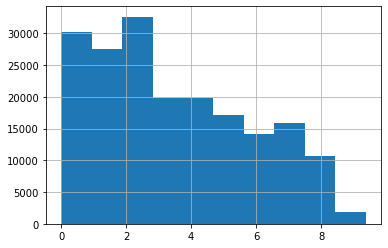

In [73]:
results_4['visiting'].hist()

<AxesSubplot:>

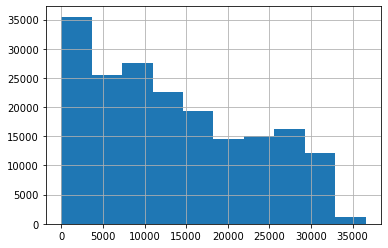

In [49]:
total_persons = (personcounts_1.iloc[:,400:800]).sum(axis=1)
total_persons.hist()

## Export results

Filter the results to the original Colouring Sydney buildings only. Optionally export results as a csv.

In [39]:
#building_results = results_2.filter(items=nodes[nodes['connect_type'] == 'poi'].index, axis=0)
# think it can just be done like this
building_results = results_4[nodes['connect_type'] == 'poi']

In [40]:
building_results.to_csv("HTS_many_bf_results_020422_Sutherland.csv")

Import building footprints and join the data to them, then export these polygons.

In [55]:
buildings_foot = gpd.read_file(folder +
    "Data\\Colouring\\Building Footprints\\sydney_bf.shp").to_crs(proj_crs)

In [60]:
results_gdf = gpd.GeoDataFrame(building_results, geometry = gpd.GeoSeries.from_xy(building_results.x, building_results.y, crs="EPSG:7856"))

In [62]:
#edit to include jobs column before export. Should reduce gpkg write time
results_gdf = results_gdf.iloc[:,[0,1,8,14, 20, 26,32,38,44,50,56,62,68,74,80,86,92,98,99,101,103,104,105]]
results_gdf

,x,y,education_13,daily needs_13.8,other goods_5.8,services_1.5,medical_3.6,errands_1.5,visiting_9.4,cultural_1.5,...,day trip_0.7,walk/jog/ride_5.1,walk dog_2.9,religious_1.5,accompany children_1.5,Walk_Index,employment,visiting,visiting_1,geometry
connect_id,,,,,,,,,,,,,,,,,,,,,
3939691,314285.652752,6.220218e+06,0.374149,0.000000,0.0,0.0,0.000000,0.057620,1.418890,0.106420,...,0.000000,1.010287,0.574477,0.000000,0.056892,4.562068,0.093833,0.092093,0.205495,POINT (314285.653 6220218.230)
3939690,314290.668466,6.220325e+06,0.360708,0.000000,0.0,0.0,0.000000,0.055550,1.367918,0.102597,...,0.000000,0.973994,0.553840,0.000000,0.054849,4.398181,0.090462,0.088784,0.198113,POINT (314290.668 6220324.929)
1492673,314432.316311,6.220200e+06,0.397349,0.000000,0.0,0.0,0.000000,0.061193,1.506872,0.103981,...,0.000000,1.003559,0.570651,0.000000,0.060420,4.727443,0.099651,0.097803,0.218237,POINT (314432.316 6220199.984)
1414358,314396.734453,6.220205e+06,0.416348,0.000000,0.0,0.0,0.000000,0.064119,1.578921,0.111738,...,0.000000,1.072927,0.610096,0.000000,0.063309,4.989701,0.104416,0.102480,0.228672,POINT (314396.734 6220205.450)
3939689,314478.101225,6.220362e+06,0.513057,0.000000,0.0,0.0,0.000000,0.079013,1.945671,0.129834,...,0.000000,1.016512,0.578016,0.000000,0.078014,5.662876,0.128670,0.126283,0.281788,POINT (314478.101 6220362.089)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3931647,335780.236784,6.235879e+06,3.282879,0.540893,0.0,0.0,0.144443,0.109745,3.504823,0.000000,...,0.331196,2.577484,0.884195,0.231984,0.000000,13.179490,0.004646,0.395584,0.882703,POINT (335780.237 6235878.890)
1785974,335760.730698,6.235889e+06,3.261616,0.537389,0.0,0.0,0.143508,0.109034,3.482123,0.000000,...,0.326742,2.560790,0.878468,0.230481,0.000000,13.091825,0.004616,0.393022,0.876986,POINT (335760.731 6235888.780)
3933061,335862.811717,6.236024e+06,2.558168,0.440082,0.0,0.0,0.117522,0.085657,2.851603,0.000000,...,0.292190,2.277512,0.691676,0.184323,0.000000,10.723424,0.003780,0.275172,0.614018,POINT (335862.812 6236024.269)


In [58]:
buildings_foot = gpd.clip(buildings_foot, Greater_Sydney)

In [63]:
# join to data
buildings_foot = gpd.sjoin(buildings_foot, results_gdf, how='left', predicate='contains')

buildings_foot.to_file("HTS_many_bf_results_020422_Sutherland.gpkg")

### Import Walkscore and compare

In [64]:
walkscore = gpd.read_file(folder +
    "Walkability\\Walkscore scraping\\Interpolation\\WS_interpolate4.gpkg")

In [65]:
walkscore = walkscore.set_crs(proj_crs, allow_override=True)

In [66]:
# join to data
results_WS = gpd.sjoin(buildings_foot, walkscore, how='right', predicate='contains', rsuffix='_ws')

In [67]:
correlations = results_WS.corr(method='pearson', min_periods=1)

In [68]:
correlations['Walk_Index']

index_left      0.042296
Shape_Leng      0.534595
Shape_Area      0.508346
index_right     0.228425
x               0.411994
                  ...   
WS.number       0.134989
Walkscore       0.489255
Walkscore.y     0.489255
interpolatew    0.801150
combinedWS      0.767386
Name: Walk_Index, Length: 111, dtype: float64

### Distance weighted feature score

In [155]:
poi_100 = {
    "employment": 100,
    "education": 100,
    "daily needs": 100,
    "other goods": 100,
    "services":100,
    "medical": 100,
    "errands": 100,
    "visiting": 100,
    "cultural": 100,
    "events": 100,
    "sports": 100,
    "restaurants": 100,
    "day trip": 100,
    "walk/jog/ride": 100,
    "walk dog": 100,
    "religious": 100,
    "accompany children": 100,
}

In [156]:
feature_score = walk_index(distance_network, pois, poi_categories, poi_weights, poi_100, distance=maximum_dist) 

Category employment is empty


C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[col_name] = access[i+1]
C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[cat_name] = ((access.applymap(access_weight,distance=distance))*


Finished category: education


C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[col_name] = access[i+1]
C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[cat_name] = ((access.applymap(access_weight,distance=distance))*


Finished category: daily needs


C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[col_name] = access[i+1]
C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[cat_name] = ((access.applymap(access_weight,distance=distance))*


Finished category: other goods


C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[col_name] = access[i+1]
C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[cat_name] = ((access.applymap(access_weight,distance=distance))*


Finished category: services


C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[col_name] = access[i+1]
C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[cat_name] = ((access.applymap(access_weight,distance=distance))*


Finished category: medical


C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[col_name] = access[i+1]
C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[cat_name] = ((access.applymap(access_weight,distance=distance))*


Finished category: errands


C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[col_name] = access[i+1]
C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[cat_name] = ((access.applymap(access_weight,distance=distance))*


Finished category: visiting


C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[col_name] = access[i+1]
C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[cat_name] = ((access.applymap(access_weight,distance=distance))*


Finished category: cultural


C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[col_name] = access[i+1]
C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[cat_name] = ((access.applymap(access_weight,distance=distance))*


Finished category: events


C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[col_name] = access[i+1]
C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[cat_name] = ((access.applymap(access_weight,distance=distance))*


Finished category: sports


C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[col_name] = access[i+1]
C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[cat_name] = ((access.applymap(access_weight,distance=distance))*


Finished category: restaurants


C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[col_name] = access[i+1]
C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[cat_name] = ((access.applymap(access_weight,distance=distance))*


Finished category: day trip


C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[col_name] = access[i+1]
C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[cat_name] = ((access.applymap(access_weight,distance=distance))*


Finished category: walk/jog/ride


C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[col_name] = access[i+1]
C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[cat_name] = ((access.applymap(access_weight,distance=distance))*


Finished category: walk dog


C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[col_name] = access[i+1]
C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[cat_name] = ((access.applymap(access_weight,distance=distance))*


Finished category: religious


C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[col_name] = access[i+1]
C:\Users\z3258367\OneDrive - UNSW\#PhD\Walkability\Other Cities\Open-Walk-Index\walkability_functions.py:125: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  results[cat_name] = ((access.applymap(access_weight,distance=distance))*


Finished category: accompany children


In [173]:
# probably just add previous visiting and employment data. wouldn't have changed. 
max(feature_score['Walk_Index'])

13.934869003332535

In [179]:
feature_score.loc[ : , [col for col in feature_score.columns if '_' in col]].iloc[:, 0:17]

,employment_29,education_13,daily needs_13.8,other goods_5.8,services_1.5,medical_3.6,errands_1.5,visiting_9.4,cultural_1.5,events_1.5,sports_4.4,restaurants_3.6,day trip_0.7,walk/jog/ride_5.1,walk dog_2.9,religious_1.5,accompany children_1.5
connect_id,,,,,,,,,,,,,,,,,
5353,0,0.032296,0.000000,0.0,0.0,0.000000,0.002696,0.058490,0.000000,0.0,0.032157,0.006626,0.000000,0.007784,0.004426,0.000000,0.002289
5347,0,0.042976,0.000000,0.0,0.0,0.000000,0.003588,0.077832,0.000000,0.0,0.042791,0.008817,0.000000,0.010358,0.005890,0.000000,0.003046
5348,0,0.041556,0.000000,0.0,0.0,0.000000,0.003469,0.075260,0.000000,0.0,0.041376,0.008525,0.000000,0.010016,0.005695,0.000000,0.002946
5350,0,0.039402,0.000000,0.0,0.0,0.000000,0.003290,0.071359,0.000000,0.0,0.039232,0.008083,0.000000,0.009497,0.005400,0.000000,0.002793
333300,0,0.019589,0.000000,0.0,0.0,0.000000,0.003017,0.071995,0.002585,0.0,0.031538,0.007413,0.000000,0.018663,0.010612,0.000000,0.002638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357487,0,0.176042,0.026107,0.0,0.0,0.006972,0.005916,0.317584,0.000000,0.0,0.026273,0.030793,0.011633,0.144765,0.049444,0.012288,0.000000
357490,0,0.177233,0.025455,0.0,0.0,0.006798,0.005768,0.310445,0.000000,0.0,0.025617,0.030109,0.011931,0.141300,0.046854,0.011981,0.000000
357489,0,0.176948,0.025604,0.0,0.0,0.006837,0.005802,0.311463,0.000000,0.0,0.025767,0.030200,0.011861,0.141008,0.046833,0.012052,0.000000


In [185]:
scores = feature_score.loc[ : , [col for col in feature_score.columns if '_' in col]]
scores.iloc[:, 0:17] = scores.iloc[:, 0:17]*100/poi_weights.values()
scores

,employment_29,education_13,daily needs_13.8,other goods_5.8,services_1.5,medical_3.6,errands_1.5,visiting_9.4,cultural_1.5,events_1.5,sports_4.4,restaurants_3.6,day trip_0.7,walk/jog/ride_5.1,walk dog_2.9,religious_1.5,accompany children_1.5,Walk_Index
connect_id,,,,,,,,,,,,,,,,,,
5353,0.0,0.248434,0.000000,0.0,0.0,0.000000,0.179758,0.622238,0.000000,0.0,0.730838,0.184048,0.000000,0.152628,0.152628,0.000000,0.152628,0.146326
5347,0.0,0.330586,0.000000,0.0,0.0,0.000000,0.239201,0.828001,0.000000,0.0,0.972513,0.244909,0.000000,0.203099,0.203099,0.000000,0.203099,0.194714
5348,0.0,0.319660,0.000000,0.0,0.0,0.000000,0.231295,0.800636,0.000000,0.0,0.940372,0.236815,0.000000,0.196387,0.196387,0.000000,0.196387,0.188279
5350,0.0,0.303090,0.000000,0.0,0.0,0.000000,0.219306,0.759133,0.000000,0.0,0.891626,0.224539,0.000000,0.186206,0.186206,0.000000,0.186206,0.178519
333300,0.0,0.150683,0.000000,0.0,0.0,0.000000,0.201116,0.765907,0.172357,0.0,0.716775,0.205915,0.000000,0.365935,0.365935,0.000000,0.175837,0.167547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357487,0.0,1.354171,0.189183,0.0,0.0,0.193663,0.394382,3.378556,0.000000,0.0,0.597115,0.855363,1.661826,2.838520,1.704970,0.819231,0.000000,0.805401
357490,0.0,1.363328,0.184456,0.0,0.0,0.188823,0.384527,3.302605,0.000000,0.0,0.582194,0.836363,1.704417,2.770584,1.615655,0.798760,0.000000,0.791116
357489,0.0,1.361136,0.185537,0.0,0.0,0.189930,0.386781,3.313438,0.000000,0.0,0.585606,0.838877,1.694485,2.764868,1.614941,0.803441,0.000000,0.791999


In [186]:
scores['visiting_9.4'] = results_4['persons']
scores['employment_29'] = results_4['jobs']

In [187]:
scores_buildings = scores[nodes['connect_type'] == 'poi']
scores_buildings.to_csv("featurescores_Sutherland.csv")

In [188]:
scores_gdf = gpd.GeoDataFrame(scores_buildings, geometry = gpd.GeoSeries.from_xy(nodes[nodes['connect_type'] == 'poi'].x, nodes[nodes['connect_type'] == 'poi'].y, crs="EPSG:7856"))

buildings_foot = gpd.read_file(folder +
    "Data\\Colouring\\Building Footprints\\sydney_bf.shp").to_crs(proj_crs)
buildings_foot = gpd.clip(buildings_foot, Sutherland)
buildings_foot = gpd.sjoin(buildings_foot, scores_gdf, how='left', predicate='contains')

buildings_foot.to_file("featurescores_Sutherland.gpkg")